# Phase 2: Establish a Baseline with YOLO

In [1]:
!pip install ultralytics roboflow ipython

import yaml
from collections import Counter
import glob
from IPython.display import clear_output, Image
import os
from roboflow import Roboflow
clear_output()

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/112.6 GB disk)


In [3]:
!nvidia-smi

Mon Jul 21 06:35:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
rf = Roboflow(api_key="NXVuNrQuQecYXJVej7bP")
project = rf.workspace("sanya-vuzrm").project("cataract-7smf8")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CATARACT-3 in yolov8:: 100%|██████████| 1242/1242 [00:00<00:00, 7144.86it/s]


In [5]:
with open(f"{dataset.location}/data.yaml", "r") as file:
    data_config = yaml.safe_load(file)
classes = data_config["names"]
train_images = len(glob.glob(f"{dataset.location}/train/images/*.jpg"))
val_images = len(glob.glob(f"{dataset.location}/valid/images/*.jpg"))
test_images = len(glob.glob(f"{dataset.location}/test/images/*.jpg"))
labels = []
for lbl_file in glob.glob(f"{dataset.location}/train/labels/*.txt"):
    with open(lbl_file, "r") as f:
        for line in f:
            class_id = int(line.split()[0])
            labels.append(class_id)
class_distribution = Counter(labels)

print(f"Dataset: Cataract-7smf8 (Roboflow Universe)")
print(f"Size: {train_images} train, {val_images} val, {test_images} test images")
print(f"Annotation Type: Bounding boxes (YOLO format)")
print(f"Num of Classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Class Distribution: {class_distribution}")
print("License: Free for non-commercial use (assumed, verify Roboflow terms)")
print("Accessibility: Easy via Roboflow API")

Dataset: Cataract-7smf8 (Roboflow Universe)
Size: 552 train, 42 val, 21 test images
Annotation Type: Bounding boxes (YOLO format)
Num of Classes: 9
Classes: ['cannula', 'crescent blade', 'fixation ring', 'forceps', 'hook', 'keratome', 'needle', 'phacoprobe', 'speculum']
Class Distribution: Counter({8: 315, 0: 210, 3: 135, 4: 99, 7: 81, 2: 68, 5: 60, 6: 15, 1: 6})
License: Free for non-commercial use (assumed, verify Roboflow terms)
Accessibility: Easy via Roboflow API


In [6]:
dataset.location

'/content/CATARACT-3'

In [7]:
NUM_OF_EPOCHS: int = 50
IMAGE_SIZE: int = 640
PLOT_WIDTH: int = 1000
PLOT_HEIGHT: int = 800

## Custom Training

In [8]:
!yolo task=detect mode=train model=yolov8m.pt data={dataset.location}/data.yaml epochs=50 imgsz=1024 plots=True

100% 49.7M/49.7M [00:00<00:00, 301MB/s]
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/CATARACT-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

In [9]:
HOME = os.getcwd()

print(HOME)

/content


In [10]:
!ls {HOME}/runs/detect/train/

args.yaml			 labels.jpg	      train_batch2.jpg
BoxF1_curve.png			 results.csv	      val_batch0_labels.jpg
BoxP_curve.png			 results.png	      val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxR_curve.png			 train_batch1400.jpg  val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch1401.jpg  weights
confusion_matrix.png		 train_batch1402.jpg
labels_correlogram.jpg		 train_batch1.jpg


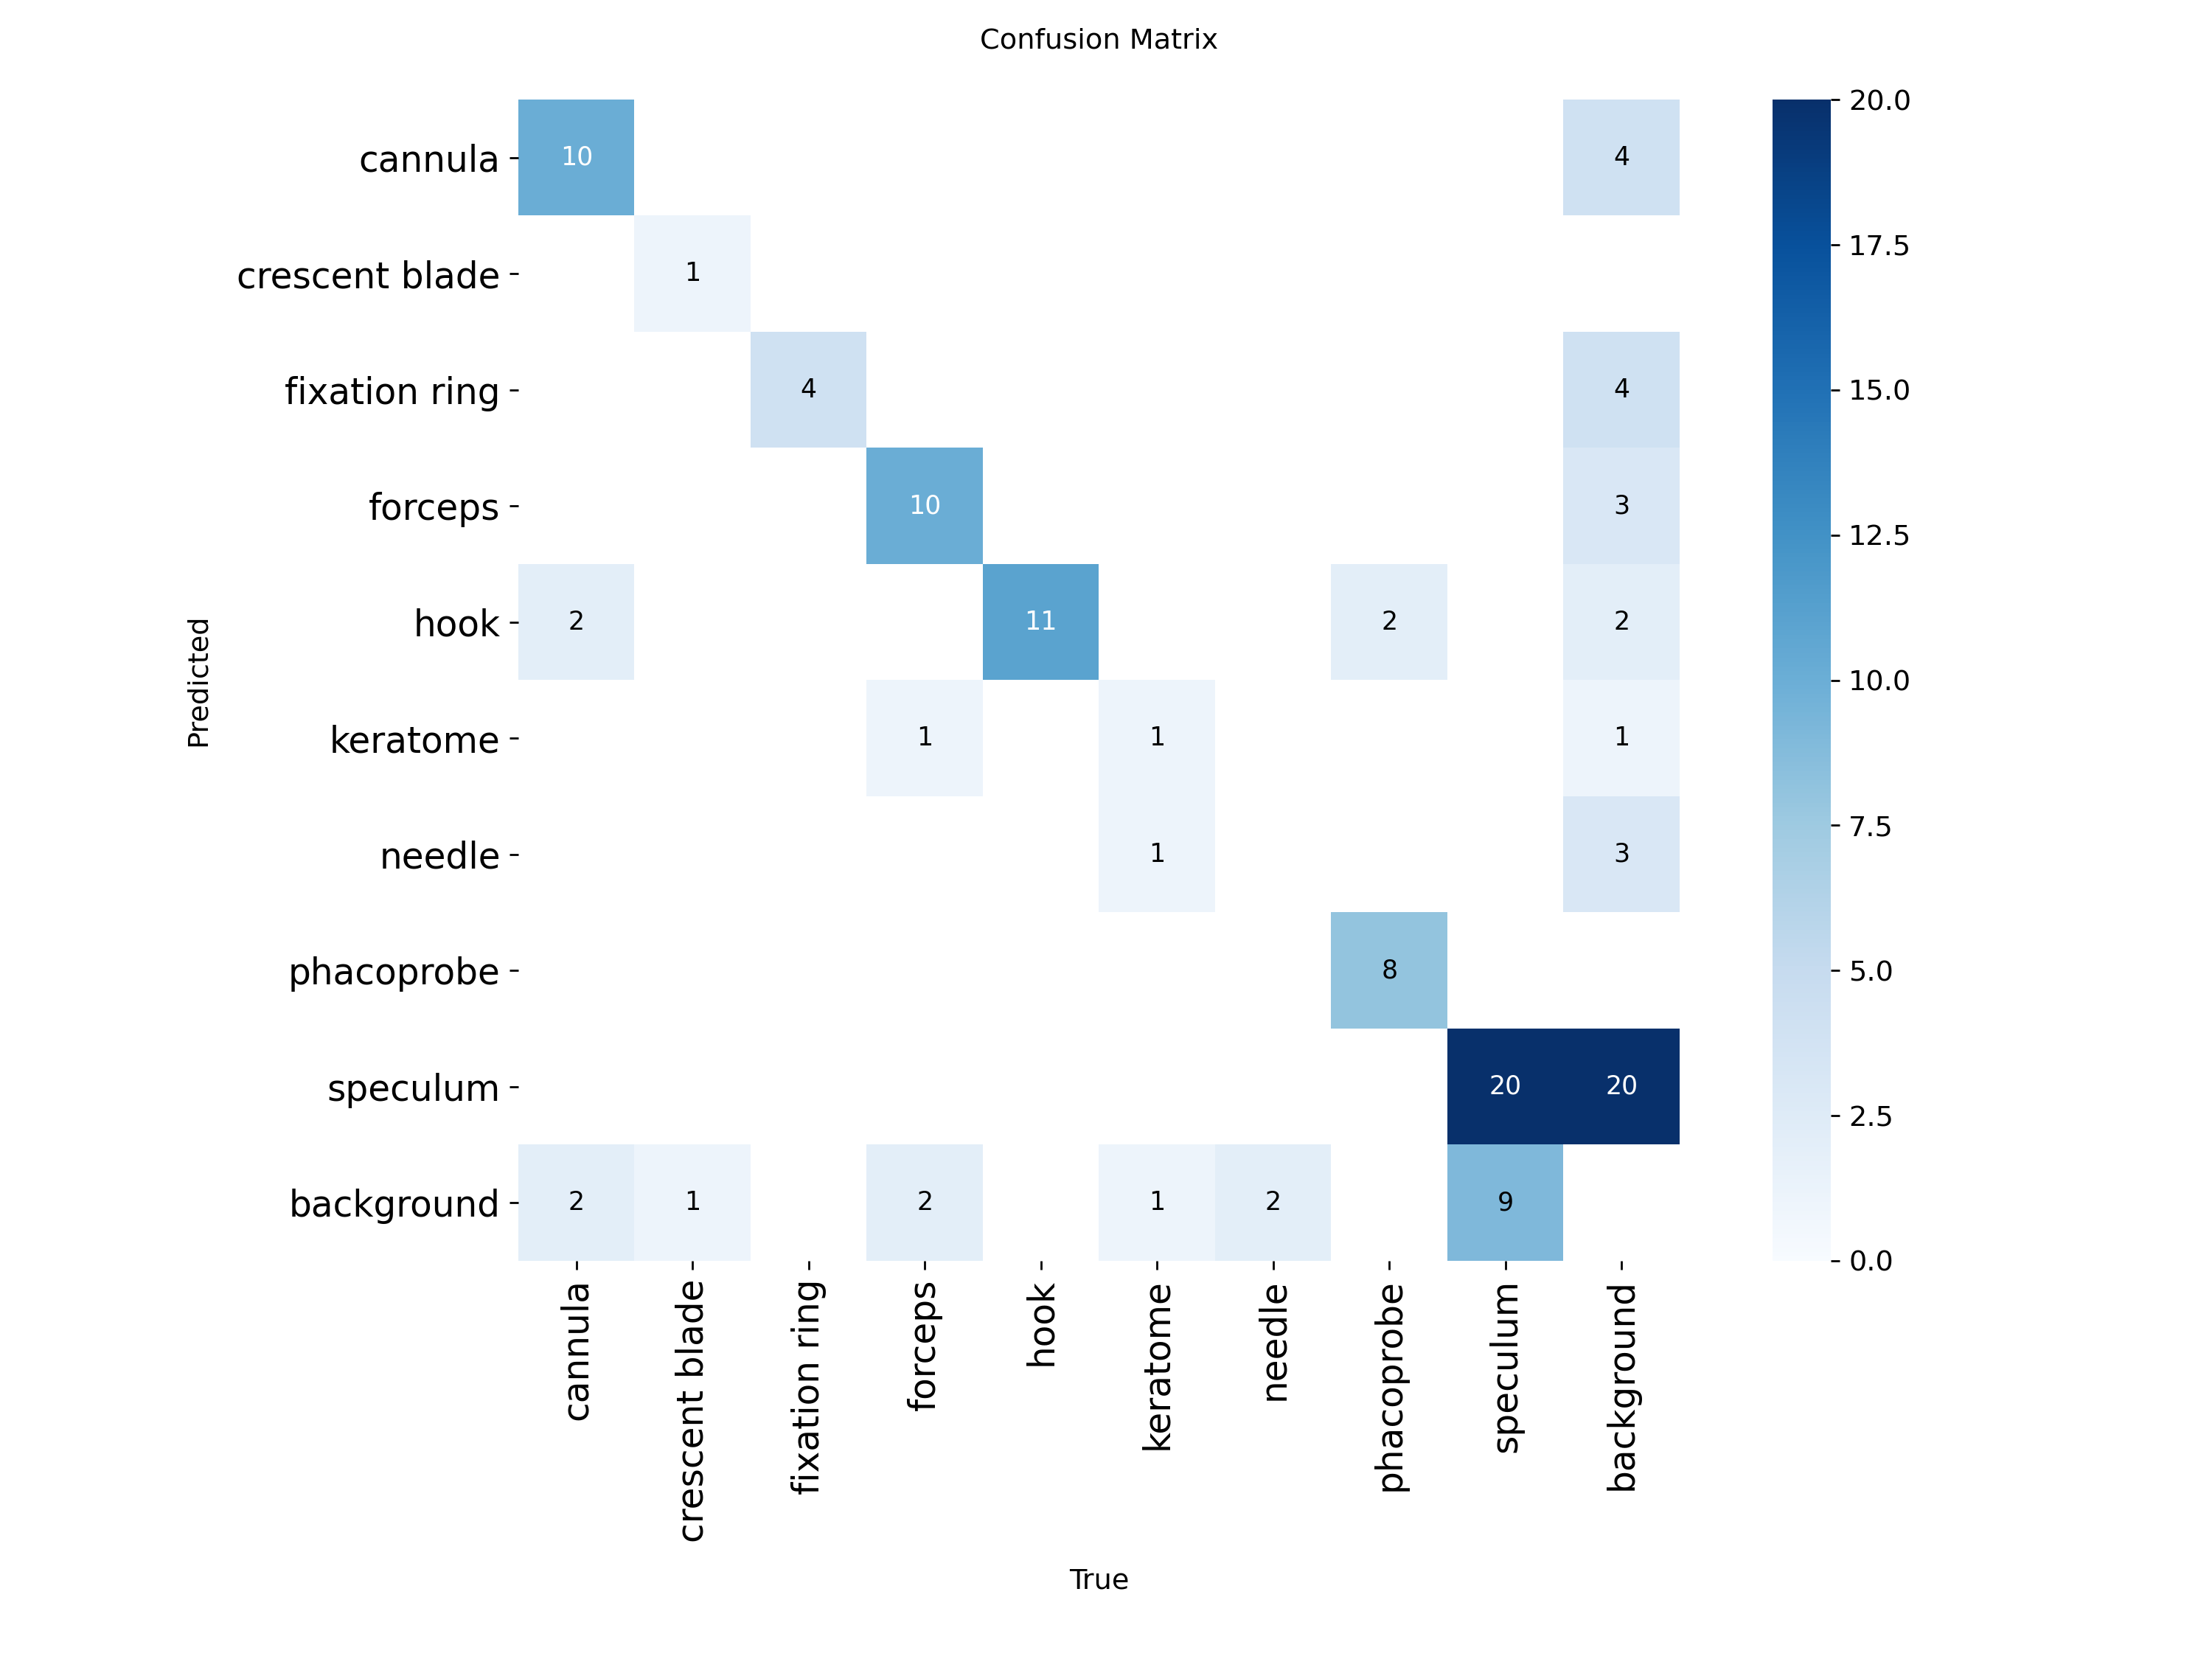

In [11]:
Image(filename=f"{HOME}/runs/detect/train/confusion_matrix.png", width=PLOT_WIDTH)

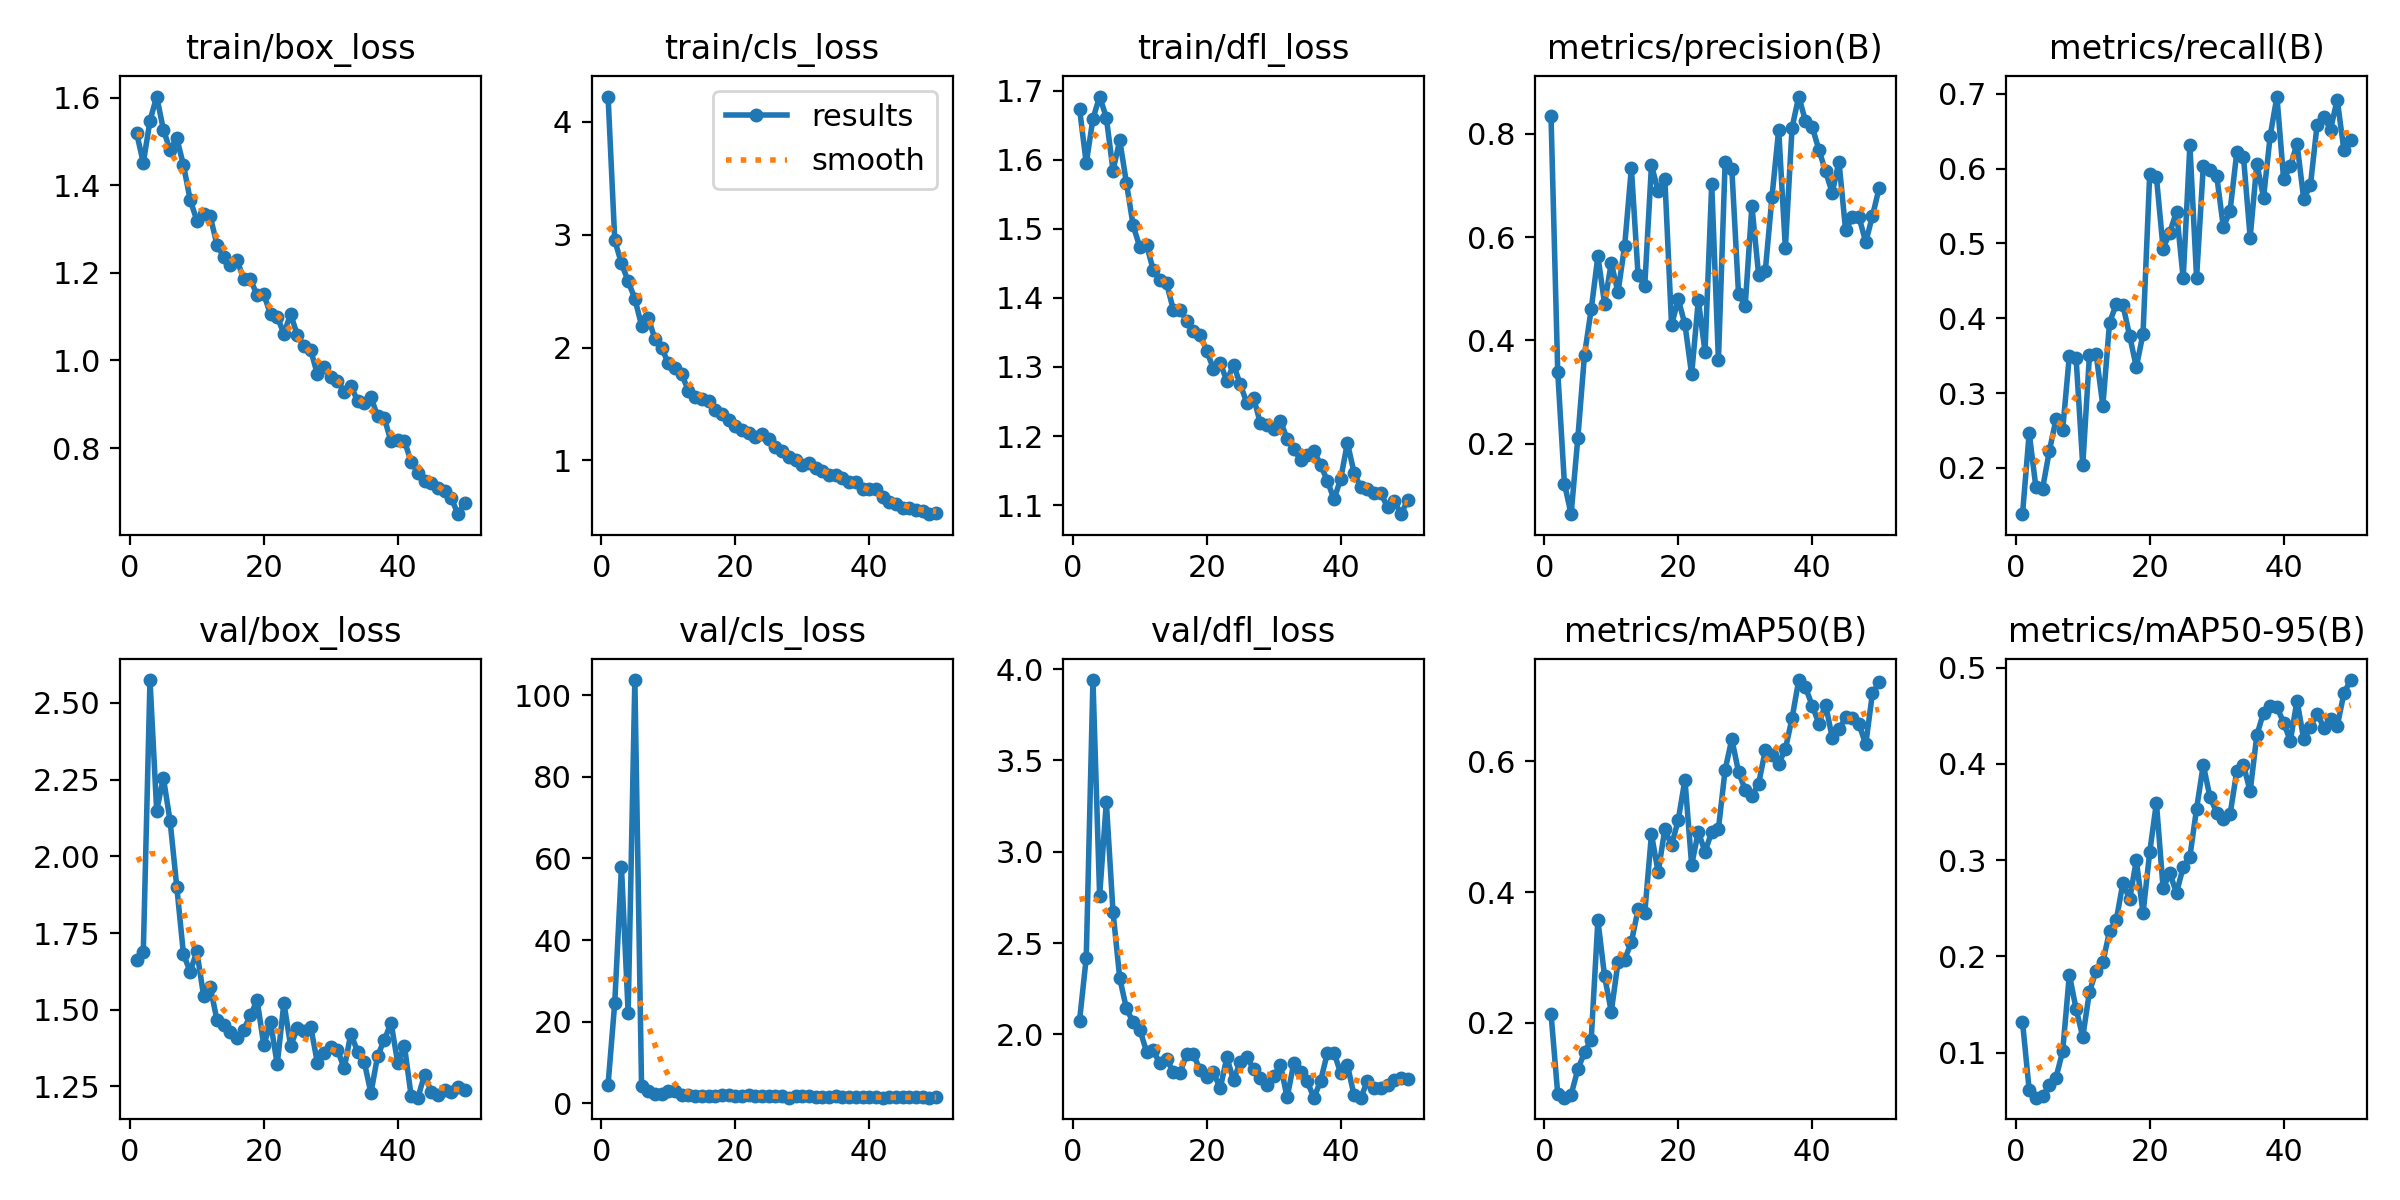

In [12]:
Image(filename=f"{HOME}/runs/detect/train/results.png", width=PLOT_WIDTH)

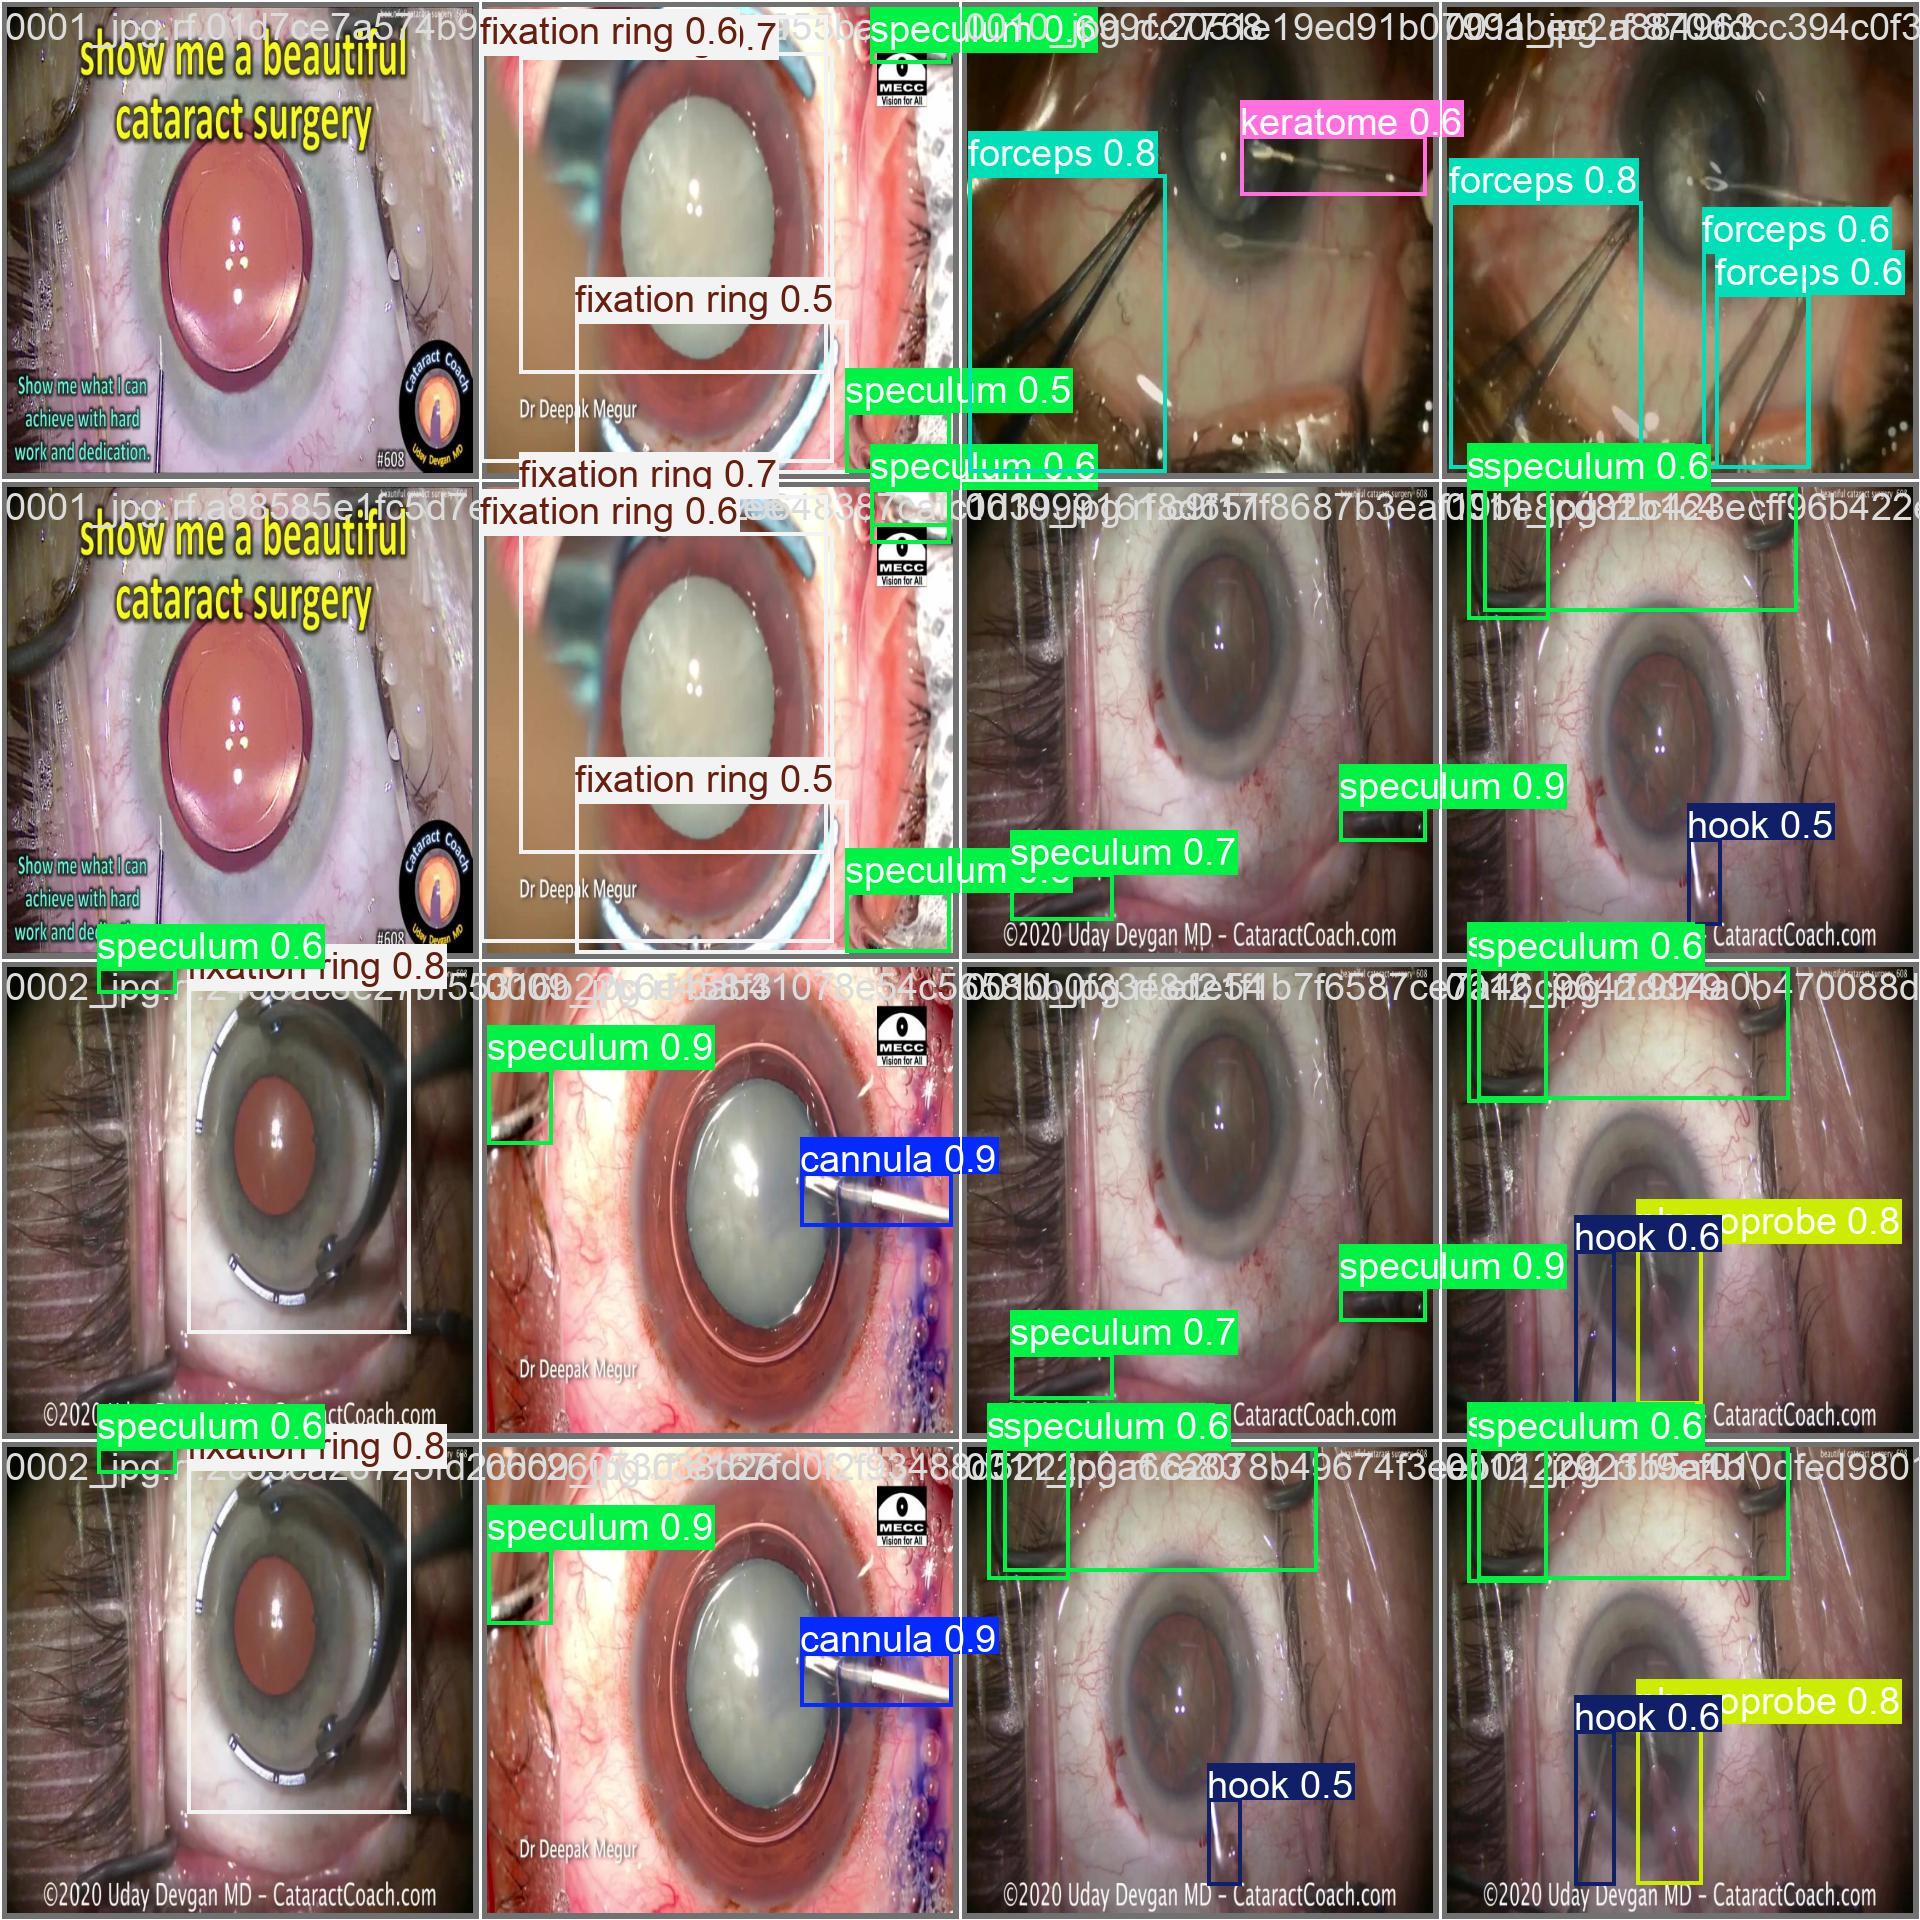

In [13]:
Image(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg", width=PLOT_WIDTH, height=PLOT_HEIGHT)

## Validate Custom Model

In [14]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,844,971 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1364.1±552.7 MB/s, size: 32.9 KB)
val: Scanning /content/CATARACT-3/valid/labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100% 42/42 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.28s/it]
                   all         42         88      0.695      0.638      0.721      0.487
               cannula         12         14      0.835      0.721      0.848      0.605
        crescent blade          2          2      0.787        0.5      0.527      0.474
         fixation ring          4          4      0.635          1      0.995      0.497
               forceps         10         13      0.908      0.769      0.795       0.62
                  hook         11         11      0.825      

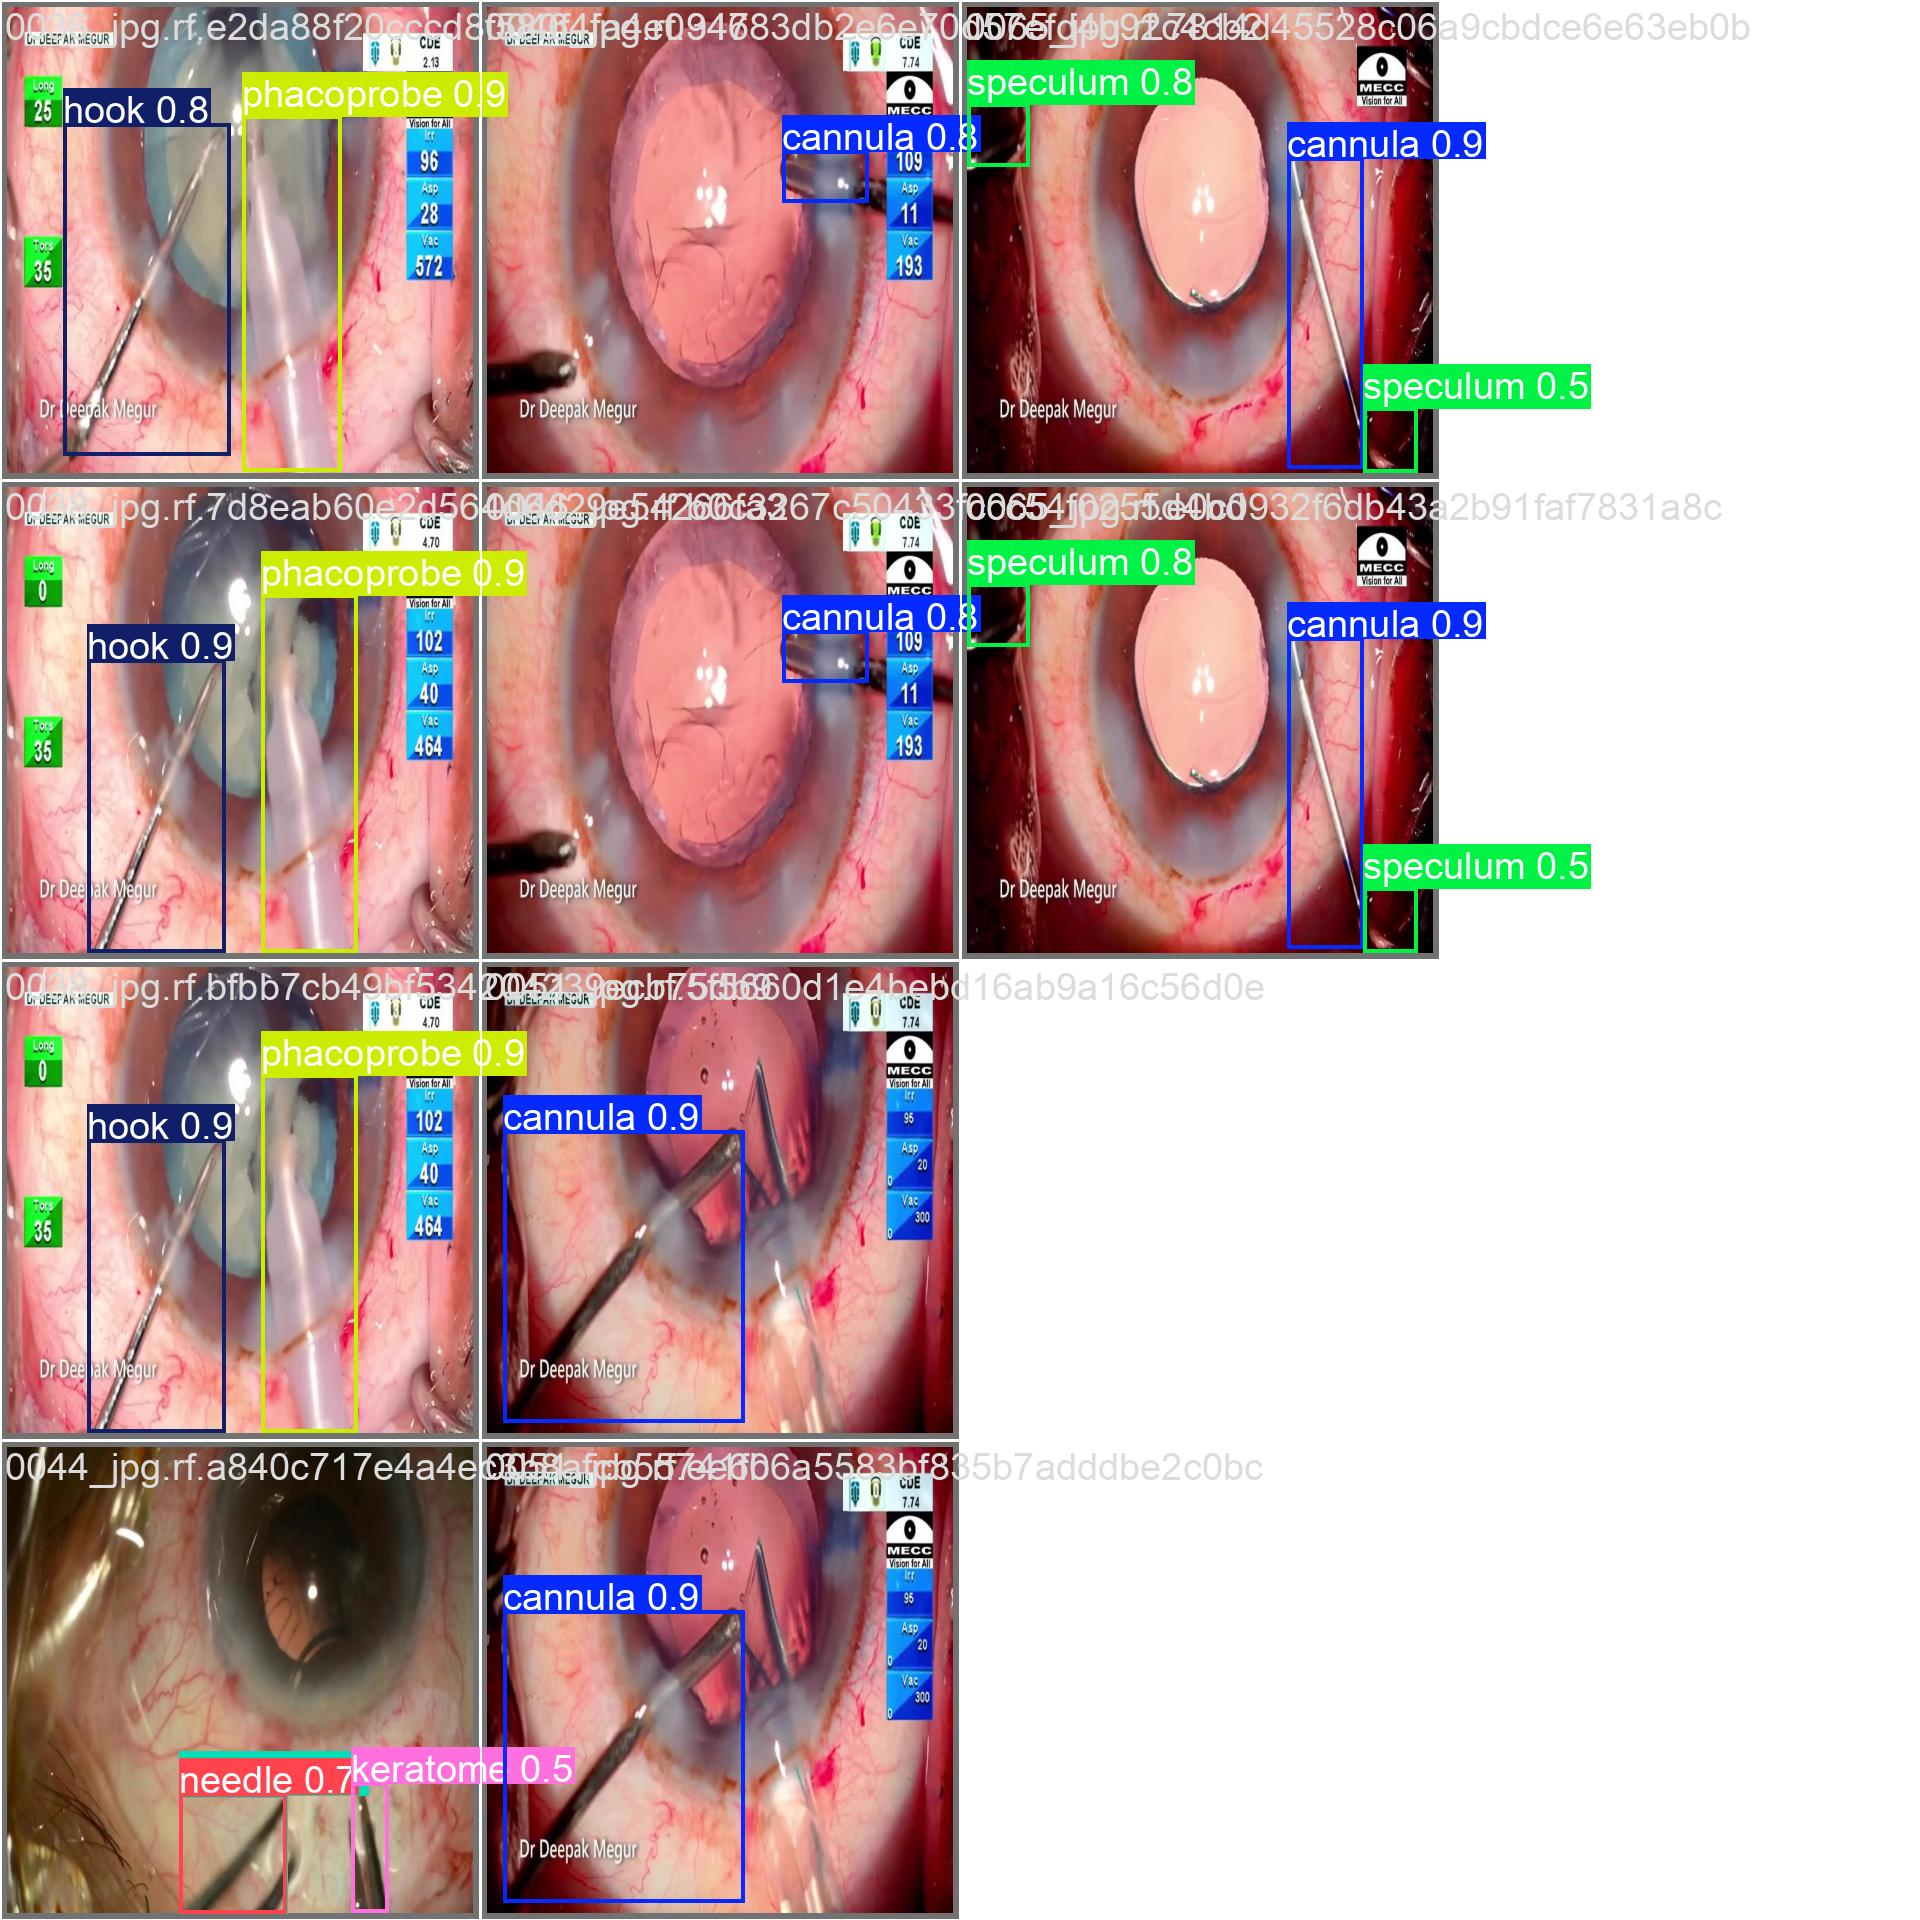

In [15]:
Image(filename=f"{HOME}/runs/detect/val/val_batch2_pred.jpg", width=PLOT_WIDTH, height=PLOT_HEIGHT)

## Inference with Custom Model

In [16]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.2 source={dataset.location}/test/images save=True

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,844,971 parameters, 0 gradients, 78.7 GFLOPs

image 1/21 /content/CATARACT-3/test/images/0002_jpg.rf.41354c145c627feb990967c90a59f849.jpg: 1024x1024 3 speculums, 77.0ms
image 2/21 /content/CATARACT-3/test/images/0002_jpg.rf.74ce4e4bde3a5f91d52ed818670b17c1.jpg: 1024x1024 3 speculums, 63.8ms
image 3/21 /content/CATARACT-3/test/images/0008_jpg.rf.17314865ad0d2b7d576a7d6fb75208ee.jpg: 1024x1024 2 forcepss, 1 keratome, 1 speculum, 63.7ms
image 4/21 /content/CATARACT-3/test/images/0014_jpg.rf.080a896fc808dee15d8786ca24098502.jpg: 1024x1024 1 hook, 1 needle, 1 phacoprobe, 2 speculums, 63.7ms
image 5/21 /content/CATARACT-3/test/images/0014_jpg.rf.c9d6c9dcf63444705c2feeac5bd42370.jpg: 1024x1024 1 hook, 1 needle, 1 phacoprobe, 2 speculums, 56.5ms
image 6/21 /content/CATARACT-3/test/images/0015_jpg.rf.f6bf0735ae36a24d02ff0813cf457eda.jpg: 1024x1024 1 forceps, 44.8ms
image 7/21 

### Let's take a look at few results.

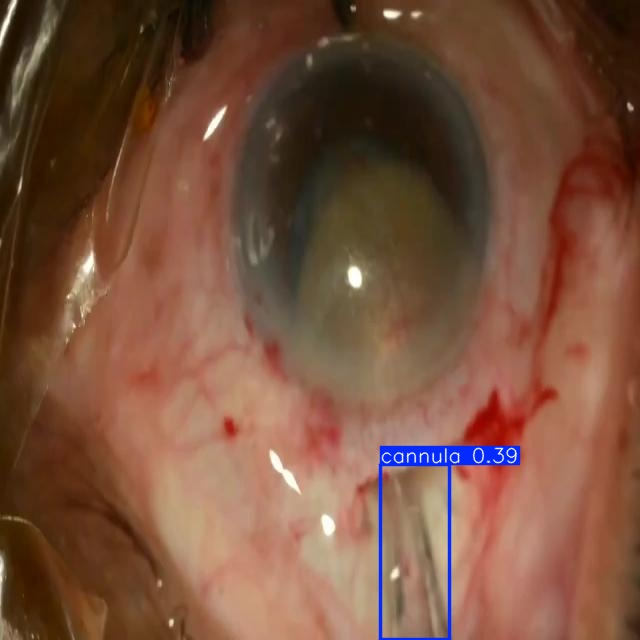

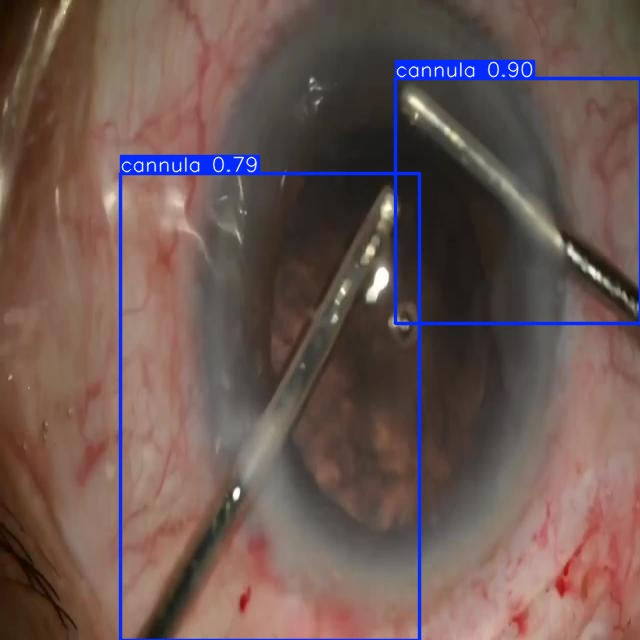

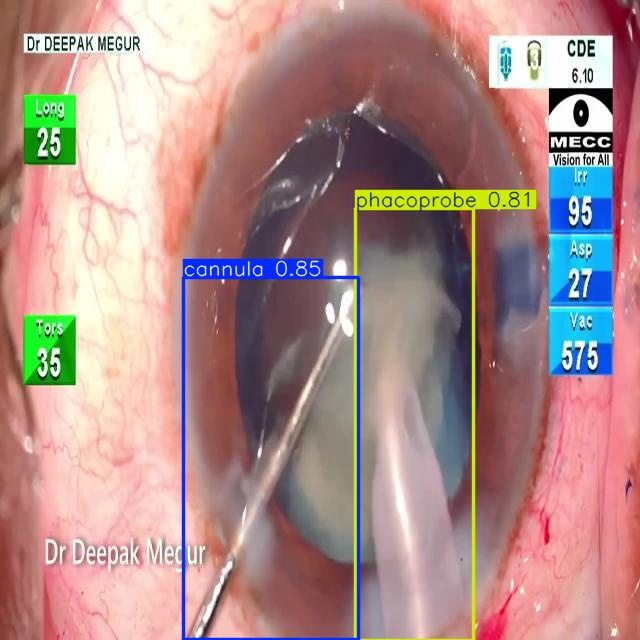

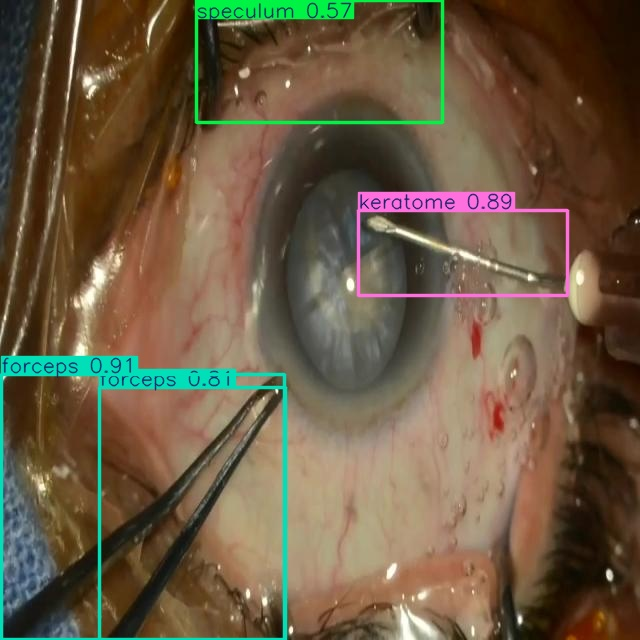

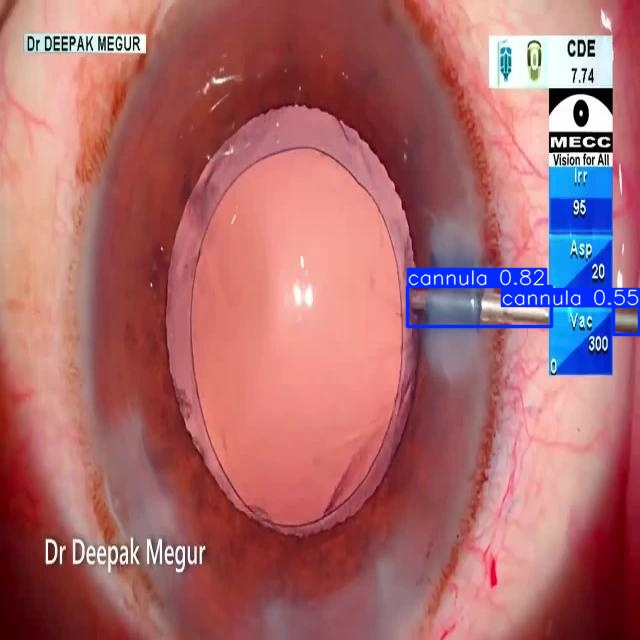

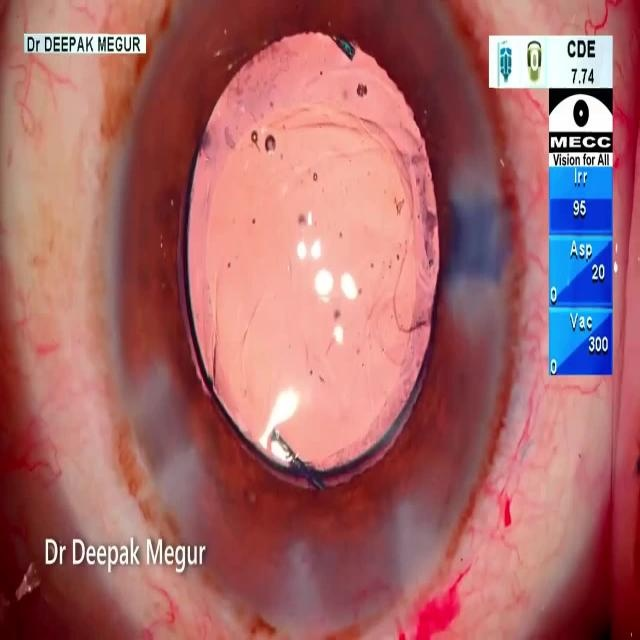

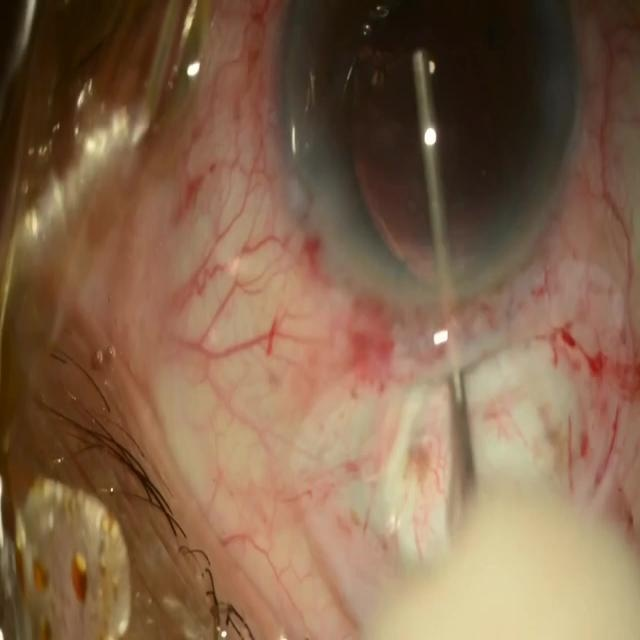

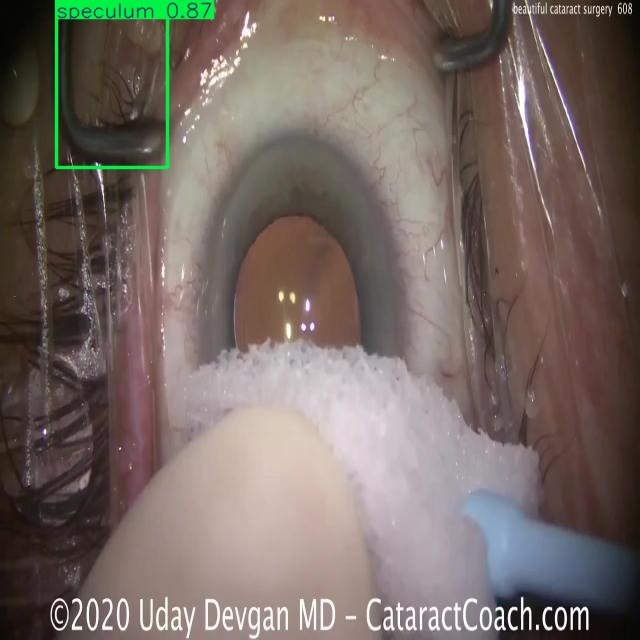

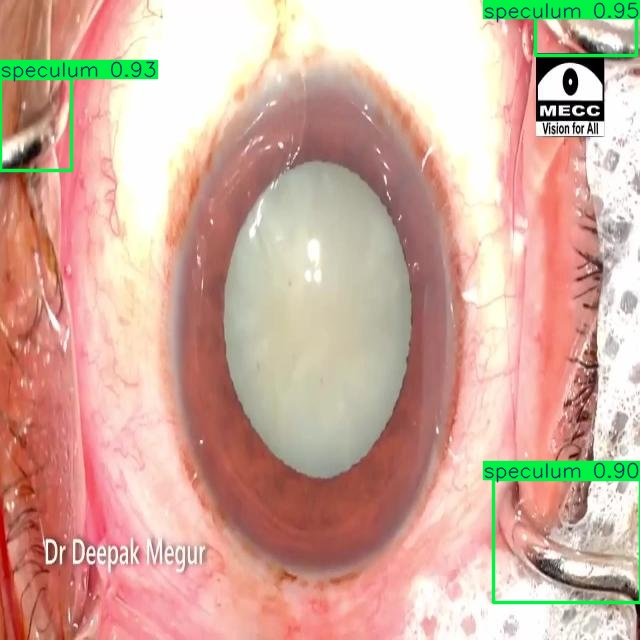

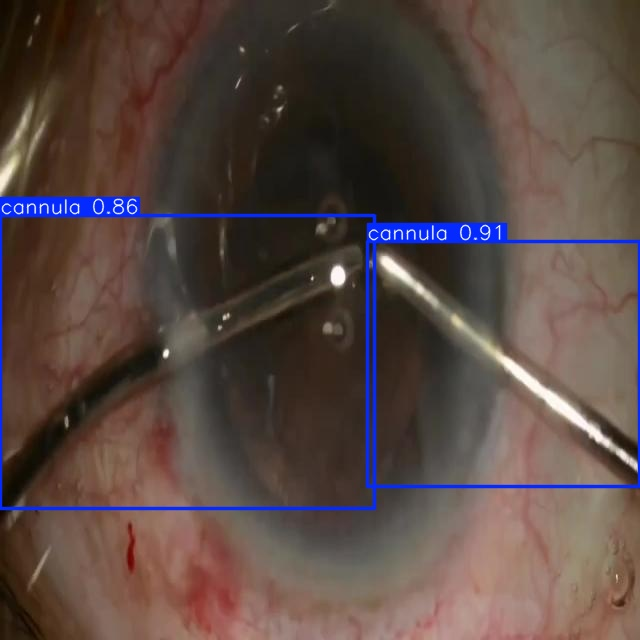

In [17]:
base_path = '/content/runs/detect/'

subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:10]

for image_path in image_paths:
    display(Image(filename=image_path, width=IMAGE_SIZE))
    print("\n")

In [23]:
model_size = os.path.getsize(f"{HOME}/runs/detect/train/weights/best.pt") / 1e6
model_size

52.119947

In [21]:
max_map50 = 0.0
max_map50_95 = 0.0
ind1 = 0
ind2 = 0
with open(f"{HOME}/runs/detect/train/results.csv", "r") as f:
    lines = f.readlines()
    for line in lines[-1:]:
        metrics = line.split(",")
        map50 = float(metrics[7])
        if map50 > max_map50:
          max_map50 = map50
          ind1 = metrics[0]
        map50_95 = float(metrics[8])
        if map50_95 > max_map50_95:
          max_map50_95 = map50_95
          ind2 = metrics[0]

In [22]:
print(f"max_map | max_map50_90\n{ max_map50:.3f}   |   {max_map50_95:.3f}")

max_map | max_map50_90
0.721   |   0.487
